# D-AGG 算法求解CVaR风险测度的Mean-Risk SLP问题
使用CVaR风险测度的两阶段随机线性规划问题可以表示为：
$$
\min_{x\in X}(1-\lambda)\mathbb{E}[f(x,\tilde{\omega})]+\lambda \phi_{CVaR_\alpha}(x)
$$
其DEP形式为：
$$
\begin{aligned}
&\min{(1-\lambda)\mathbf{c}^{\mathrm{T}}\mathbf{x}+(1-\lambda)\sum_{\omega\in\Omega}{p(\omega)\mathbf{q}^{\mathrm{T}}\mathbf{y}(\omega)+\lambda \eta+\frac{\lambda}{1-\alpha}\sum_{\omega\in\Omega}{p(\omega)y(\omega)}}} \\
s.t. & \mathbf{Tx}+\mathbf{Wy}\geq \mathbf{r}(\omega), \forall \omega\in\Omega \\
& -\mathbf{c}^{\mathrm{T}}\mathbf{x}-\mathbf{q}^{\mathrm{T}}\mathbf{y}(\omega)+\eta+v(\omega)\geq 0, \forall \omega\in\Omega \\
& x\in X, y(\omega)\in \mathbb{R}_+^{n_2},v(\omega)\in \mathbb{R}_+,\forall \omega\in\Omega
\end{aligned}
$$
根据书中D-AGG算法描述，设计如下代码

In [ ]:
using JuMP, Gurobi
import MathOptInterface as MOI
# parameters
# first stage
const c=[50,30,15,10]
const A=[-1 0 0 0;0 -1 0 0;0 0 -1 0;0 0 0 -1;0 -1 -1 -1]
const b=[-300,-700,-600,-500,-1600]
# second stage
const S=5
const p=[0.15,0.3,0.3,0.2,0.05]
const q=[-1150,-1525,-1900]
const W=[-6 -8 -10;-20 -25 -28;-12 -15 -18;-8 -10 -14;-1 0 0;0 -1 0;0 0 -1]
const T=[1 0 0 0;0 1 0 0;0 0 1 0;0 0 0 1;0 0 0 0;0 0 0 0;0 0 0 0]
const r1=[0,0,0,0,-15,-10,-5]
const r2=[0,0,0,0,-25,-20,-15]
const r3=[0,0,0,0,-25,-20,-25]
const r4=[0,0,0,0,-30,-25,-30]
const r5=[0,0,0,0,-10,-10,-10]
const r=[r1,r2,r3,r4,r5]
const λ=0.5 #CVaR权重
const δl=-5000 
const δu=0
const α=0.95 #置信水平
const max_iter=30

30

In [ ]:
MP=Model(Gurobi.Optimizer)
set_silent(MP)
@variable(MP, x[1:4]>=0)
@variable(MP,δl<=η<=δu)
@variable(MP,γ>=-1e6) #γ进行松弛以保证可行性
@objective(MP,Min,(1-λ)*c'*x+λ*η+γ)
@constraint(MP,A*x.>=b)
optimize!(MP)

Set parameter LicenseID to value 2632898


In [ ]:
function add_aggregate_cut!(MP::Model)
    x_value=value.(x)
    η_value=value(η)
    obj=0
    is_feas=true
    βk=zeros((4,))
    βk1=0
    βk0=0
    for s in 1:S
        SP=Model(Gurobi.Optimizer)
        set_silent(SP)
        set_attribute(SP,"InfUnbdInfo",1)
        set_attribute(SP,"DualReductions",0)
        @variable(SP,y[1:3]>=0)
        @variable(SP,v>=0)
        @objective(SP,Min, (1-λ)*q'*y+λ/(1-α)*v)
        @constraint(SP,cons1, W*y.>=r[s]-T*x_value)
        @constraint(SP,cons2,-q'*y+v>=-η_value+c'*x_value)
        optimize!(SP)
        if termination_status(SP)!=MOI.OPTIMAL
            is_feas=false
            μ=dual.(cons1)
            μ0=dual(cons2)
            βk=T'*μ-μ0*c
            βk1=μ0
            βk0=μ'*r[s]
            @constraint(MP,βk'*x+βk1*η>=βk0) #可行割
            return (is_feas=is_feas,uk=obj)
        else
            πk=dual.(cons1)
            πk0=dual(cons2)
            βk+=vec(p[s]*(T'*πk - πk0*c))
            βk1+=p[s]*πk0
            βk0+=p[s]* (πk'*r[s])
            obj+=objective_value(SP)*p[s]
        end
    end
    @constraint(MP,βk'*x+βk1*η+γ>=βk0) #最优割
    return (is_feas=is_feas,uk=obj+(1-λ)*c'*x_value+λ*η_value)
end

add_aggregate_cut! (generic function with 1 method)

In [5]:
result=add_aggregate_cut!(MP)
optimize!(MP)
u_history=[]
l_history=[]
# iterative process
k=0
l=-Inf
u=Inf
ϵ=0.1
if result.is_feas
    u=min(u,result.uk)
end
l=max(l,objective_value(MP))
push!(u_history,u)
push!(l_history,l)
while k<max_iter && u-l>ϵ
    global k+=1
    println("Iteration $k: Lower bound=$l, Upper bound=$u")
    res=add_aggregate_cut!(MP)
    optimize!(MP)
    global l=max(l,objective_value(MP))
    if res.is_feas
        global u=min(u,res.uk)
    end
    push!(u_history,u)
    push!(l_history,l)
end
println("Final solution after $k iterations: Lower bound=$l, Upper bound=$u")
println("Optimal first stage decision variables:")
for i in 1:4
    println("x[$i] = ", value(x[i]))
end

Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Iteration 1: Lower bound=-446249.99999999965, Upper bound=47499.999999999956
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Iteration 2: Lower bound=-148141.30434782602, Upper bound=47499.999999999956
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Iteration 3: Lower bound=-77266.30434782604, Upper bound=47499.999999999956
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value

可以看出与Risk-Neutral 情况相比，考虑风险后，第一阶段的决策变量x最优值有所下降以减少潜在的高损失风险，同时整体收益也有所降低。

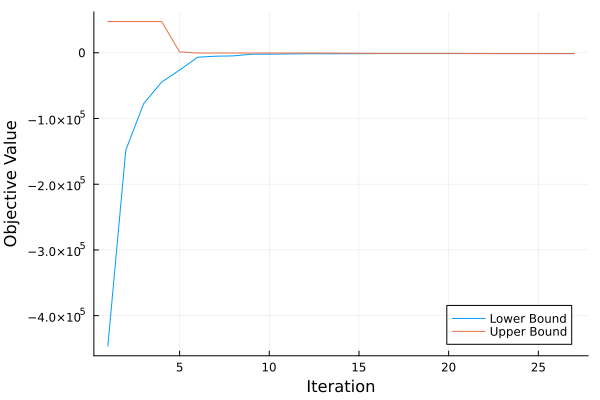

In [6]:
using Plots
plot(l_history, label="Lower Bound", xlabel="Iteration", ylabel="Objective Value", legend=:bottomright)
plot!(u_history, label="Upper Bound")